# Used Car Prices CarGurus: Linear GPU
## Optuna Hyperparameter Optimization

## Set Up Environment, Read Data, Split Train/Test Sets

In [1]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/RAPIDS

/content/drive/MyDrive/RAPIDS


In [ ]:
!pip install pynvml==11.4.1
# Clone RAPIDS-Colab install files and see if GPU is compatible
#!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/env-check.py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached pynvml-11.4.1-py3-none-any.whl (46 kB)
***********************************************************************
Woo! Your instance has the right kind of GPU, a Tesla T4!
***********************************************************************



In [ ]:
# Update the Colab environment and restart the kernel
!bash rapidsai-csp-utils/colab/update_gcc.sh
import os
os._exit(00)

In [ ]:
# Install CondaColab and restart the kernel 
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:37
🔁 Restarting kernel...


In [ ]:
# See if environment is ready to install RAPIDS
import condacolab
condacolab.check()

✨🍰✨ Everything looks OK!


In [ ]:
# Install RAPIDS using the 'stable' release
!python rapidsai-csp-utils/colab/install_rapids.py stable
import os
os.environ['NUMBAPRO_NVVM'] = '/usr/local/cuda/nvvm/lib64/libnvvm.so'
os.environ['NUMBAPRO_LIBDEVICE'] = '/usr/local/cuda/nvvm/libdevice/'
os.environ['CONDA_PREFIX'] = '/usr/local'

In [ ]:
# Install/import dependencies
!pip install pynvml==11.4.1
!pip install optuna
!pip install dask_optuna
import os
import random
import warnings
import time
from contextlib import contextmanager
import numpy as np
import cupy 
import cudf
import cuml
from dask.distributed import Client, wait
from dask_cuda import LocalCUDACluster
import dask, dask_cudf
from dask.diagnostics import ProgressBar
import dask_optuna
import urllib.request
from cuml.preprocessing import train_test_split
from cuml.svm import LinearSVR
import time
from datetime import datetime, timedelta
from timeit import default_timer as timer
import joblib
from joblib import parallel_backend
import optuna
from optuna import Trial
optuna.logging.set_verbosity(optuna.logging.WARNING) 
import pickle
import pandas as pd
import sklearn
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import plotly.offline as py
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')
my_dpi = 96

# Set seed 
seed_value = 42
os.environ['usedCars_lsvrGPU'] = str(seed_value)
cupy.random.seed(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

# Define function to time code blocks
@contextmanager
def timed(name):
    t0 = time.time()
    yield
    t1 = time.time()
    print('..%-24s:  %8.4f' % (name, t1 - t0))

print('\n')
!nvidia-smi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Sat Feb 25 22:24:49 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    25W /  7

In [ ]:
# Set up local CUDA cluster for Dask
cluster = LocalCUDACluster(threads_per_worker=1, ip='', 
                           dashboard_address='8081') 
c = Client(cluster)

# Query the client for all connected workers
workers = c.has_what().keys()
n_workers = len(workers)
c

Connection method: Cluster object,Cluster type: dask_cuda.LocalCUDACluster
Dashboard: http://172.28.0.12:8081/status,
Dashboard: http://172.28.0.12:8081/status,Workers: 1
Total threads: 1,Total memory: 25.45 GiB
Status: running,Using processes: True
Comm: tcp://172.28.0.12:39715,Workers: 1
Dashboard: http://172.28.0.12:8081/status,Total threads: 1
Started: Just now,Total memory: 25.45 GiB
Comm: tcp://172.28.0.12:40501,Total threads: 1
Dashboard: http://172.28.0.12:39123/status,Memory: 25.45 GiB
Nanny: tcp://172.28.0.12:41645,


In [ ]:
%cd /content/drive/MyDrive/UsedCarsCarGurus/Data

/content/drive/MyDrive/UsedCarsCarGurus/Data


In [ ]:
# Read data
trainDF = cudf.read_csv('usedCars_trainSet.csv', low_memory=False)
print('Train set: Number of rows and columns:', trainDF.shape)

testDF  = cudf.read_csv('usedCars_trainSet.csv', low_memory=False)
print('Test set: Number of rows and columns:', testDF.shape)

# Set up train/test split
X_train, y_train = trainDF.drop('price', 
                                axis=1), trainDF['price'].astype('int32')
X_test, y_test = testDF.drop('price', 
                             axis=1), testDF['price'].astype('int32')

# Dummy variables for categorical variables
X_train = cudf.get_dummies(X_train)
X_test = cudf.get_dummies(X_test)

# Convert data types for modeling
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

Train set: Number of rows and columns: (262329, 54)
Test set: Number of rows and columns: (262329, 54)


## LinearSVR

## 100 Trials

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/UsedCarsCarGurus/Models/ML/LinearSVR/Optuna/Model_PKL

# Define a name for the trials
study_name = 'dask_optuna_linearsvr_100_rmse_tpe'

/content/drive/MyDrive/UsedCarsCarGurus/Models/ML/LinearSVR/Optuna/Model_PKL


In [ ]:
# Define function to train/evaluate the model
def train_and_eval(X_param, y_param, penalty='l2', 
                   loss='epsilon_insensitive', 
                   penalized_intercept='False', 
                   max_iter=10000, 
                   linesearch_max_iter=100, 
                   lbfgs_memory=5, C=10, 
                   grad_tol=0.0001, change_tol=1e-5, 
                   epsilon=0.1, verbose=False): 
    """
        Partition data into train/test sets, train and evaluate the model
        for the given parameters.
        
        Params
        ______
        
        X_param:  DataFrame. 
                  The data to use for training and testing. 
        y_param:  Series. 
                  The label for training

        Returns
        score: RMSE of the fitted model
    """
    # Prepare the data for modeling
    X_train, y_train = trainDF.drop('price', 
                                    axis=1), trainDF['price'].astype('int32')
    X_train = cudf.get_dummies(X_train)
    X_train = X_train.astype('float32')

    X_test, y_test = testDF.drop('price', 
                                 axis=1), testDF['price'].astype('int32')
    X_test = cudf.get_dummies(X_test)
    X_test = X_test.astype('float32')

    # Define model
    model = LinearSVR(penalty=penalty,
                      loss=loss, 
                      penalized_intercept=penalized_intercept, 
                      max_iter=max_iter, 
                      linesearch_max_iter=linesearch_max_iter, 
                      lbfgs_memory=lbfgs_memory, 
                      C=C, 
                      grad_tol=grad_tol, 
                      change_tol=change_tol, 
                      epsilon=epsilon, 
                      verbose=False)  
    
    # Start timer for each trial
    start = timer()

    # Fit model
    model.fit(X_train, y_train)
    run_time = timer() - start

    # Predict on the model
    y_pred = model.predict(X_test)
    score = mean_squared_error(y_test.to_numpy(), y_pred.to_numpy(), 
                               squared=False)
    print('- Trial RMSE:', score)
    
    return score

In [ ]:
# Fit default model
print('Score with default parameters : ', train_and_eval(X_train, y_train))

- Trial RMSE: 5575.5416810608285
Score with default parameters :  5575.5416810608285


In [ ]:
# Define objective function with the parameters to be tested
def objective(trial, X_param, y_param):
    
    joblib.dump(study, 'LinearSVR_Optuna_100_GPU.pkl')
    
    # Search parameters
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    loss = trial.suggest_categorical('loss', ['squared_epsilon_insensitive', 
                                              'epsilon_insensitive']) 
    penalized_intercept = trial.suggest_categorical('penalized_intercept', 
                                                    ['True', 'False'])
    max_iter = trial.suggest_int('max_iter', -1, 10e6)
    linesearch_max_iter = trial.suggest_int('linesearch_max_iter', 100, 10000)  
    lbfgs_memory = trial.suggest_int('lbfgs_memory', 5, 20) 
    C = trial.suggest_float('C', 0.1, 10, step=0.1)
    grad_tol = trial.suggest_float('grad_tol', 1e-3, 1e-1)
    change_tol = trial.suggest_float('change_tol', 1e-53, 1e-3) 
    epsilon = trial.suggest_float('epsilon', 0.1, 1, step=0.1) 

    score = train_and_eval(X_param,
                           y_param,
                           penalty=penalty, 
                           loss=loss, 
                           penalized_intercept=penalized_intercept, 
                           max_iter=max_iter, 
                           linesearch_max_iter=linesearch_max_iter, 
                           lbfgs_memory=lbfgs_memory, 
                           C=C, 
                           grad_tol=grad_tol, 
                           change_tol=change_tol, 
                           epsilon=epsilon, 
                           verbose=False)

    return score

In [ ]:
with timed('dask_optuna'):
    # Begin HPO trials 
    # Start timer for experiment
    start_time = datetime.now()
    print('%-20s %s' % ('Start Time', start_time))
    if os.path.isfile('LinearSVR_Optuna_100_GPU.pkl'): 
      study = joblib.load('LinearSVR_Optuna_100_GPU.pkl')
    else: 
      study = optuna.create_study(sampler=optuna.samplers.TPESampler(), 
                                  study_name=study_name,
                                  direction='minimize')
      
    # Optimize in parallel on Dask cluster
    with parallel_backend('dask'):
      study.optimize(lambda trial: objective(trial, X_train, y_train), 
                       n_trials=100,
                       n_jobs=n_workers)

# End timer for experiment
end_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
print('%-20s %s' % ('End Time', end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))
print('\n')
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Lowest RMSE', study.best_value)

Start Time           2023-02-25 23:50:56.293667
[W] [23:50:56.427957] L-BFGS line search failed (code 4); stopping at the last valid step
- Trial RMSE: 26291.337152238986
- Trial RMSE: 7535.842464053334
- Trial RMSE: 7530.242642970948
- Trial RMSE: 7530.105890537713
- Trial RMSE: 7458.727932807972
- Trial RMSE: 8837.276498303228
- Trial RMSE: 11754.918061375976
[W] [23:50:58.150168] L-BFGS line search failed (code 4); stopping at the last valid step
- Trial RMSE: 26291.330337813542
- Trial RMSE: 11537.177115115734
- Trial RMSE: 7460.118440622301
- Trial RMSE: 7483.234166128581
- Trial RMSE: 7452.7782792252365
- Trial RMSE: 7452.778279014081
- Trial RMSE: 7854.828680819211
- Trial RMSE: 7853.928435853973
- Trial RMSE: 7458.727637712311
- Trial RMSE: 7849.856568816009
- Trial RMSE: 7452.7782784181645
[W] [23:51:00.630111] L-BFGS line search failed (code 4); stopping at the last valid step
- Trial RMSE: 26291.336411377986
- Trial RMSE: 7853.5249945824025
- Trial RMSE: 7460.118403731107
- 

In [ ]:
# Output from HPO trials
trials_df = study.trials_dataframe()
trials_df.rename(columns={'number': 'iteration'}, inplace=True)
trials_df.rename(columns={'value': 'rmse'}, inplace=True)
trials_df.rename(columns={'params_C': 'C'}, inplace=True)
trials_df.rename(columns={'params_change_tol': 'change_tol'}, inplace=True)
trials_df.rename(columns={'params_epsilon': 'epsilon'}, inplace=True)
trials_df.rename(columns={'params_grad_tol': 'grad_tol'}, inplace=True)
trials_df.rename(columns={'params_lbfgs_memory': 'lbfgs_memory'}, inplace=True)
trials_df.rename(columns={'params_linesearch_max_iter': 'linesearch_max_iter'}, 
                 inplace=True)
trials_df.rename(columns={'params_loss': 'loss'}, inplace=True)
trials_df.rename(columns={'params_max_iter': 'max_iter'}, inplace=True)
trials_df.rename(columns={'params_penalized_intercept': 'penalized_intercept'}, 
                 inplace=True)
trials_df.rename(columns={'params_penalty': 'penatly'}, inplace=True)
trials_df = trials_df.sort_values('rmse', ascending=True)
print(trials_df) 

# Write processed data to csv
trials_df.to_csv('LinearSVR_Optuna_100_GPU.csv', index=False)

    iteration          rmse             datetime_start  \
68         68   4911.220907 2023-02-25 23:51:22.958612   
77         77   4915.918857 2023-02-25 23:51:33.536008   
96         96   4925.311056 2023-02-25 23:51:50.782685   
40         40   4926.788107 2023-02-25 23:51:06.969764   
91         91   4927.204516 2023-02-25 23:51:45.090319   
..        ...           ...                        ...   
26         26  26291.322849 2023-02-25 23:51:02.174237   
7           7  26291.330338 2023-02-25 23:50:57.934892   
29         29  26291.333488 2023-02-25 23:51:02.810908   
18         18  26291.336411 2023-02-25 23:51:00.471562   
0           0  26291.337152 2023-02-25 23:50:56.296696   

            datetime_complete               duration    C    change_tol  \
68 2023-02-25 23:51:25.654281 0 days 00:00:02.695669  6.1  5.945861e-05   
77 2023-02-25 23:51:36.032654 0 days 00:00:02.496646  5.7  5.173426e-07   
96 2023-02-25 23:51:53.913946 0 days 00:00:03.131261  5.6  3.800069e-06   
40 

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/UsedCarsCarGurus/Models/ML/LinearSVR/Optuna/Model_Explanations/

/content/drive/MyDrive/UsedCarsCarGurus/Models/ML/LinearSVR/Optuna/Model_Explanations


In [ ]:
# Plot_optimization_history: shows the scores from all trials as well as the best score so far at each point.
fig = optuna.visualization.plot_optimization_history(study)
py.plot(fig, filename='optimizationHistory_LinearSVR_Optuna_100_GPU.html')
fig.show()

In [ ]:
# plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
fig = optuna.visualization.plot_parallel_coordinate(study)
py.plot(fig, filename='parallelCoordinate_LinearSVR_Optuna_100_GPU.html')
fig.show()

In [ ]:
# plot_slice: shows the change of the hyperparamters space over the search. 
fig = optuna.visualization.plot_slice(study)
py.plot(fig, filename='slice_LinearSVR_Optuna_100_GPU.html')
fig.show()

In [ ]:
# plot_contour: plots parameter interactions on an interactive chart. 
fig = optuna.visualization.plot_contour(study, params=['C',
                                                       'epsilon',
                                                       'change_tol',
                                                       'grad_tol',
                                                       'lbfgs_memory',
                                                       'linesearch_max_iter',
                                                       'max_iter'])
py.plot(fig, filename='contour_LinearSVR_Optuna_100_GPU.html')
fig.show() 

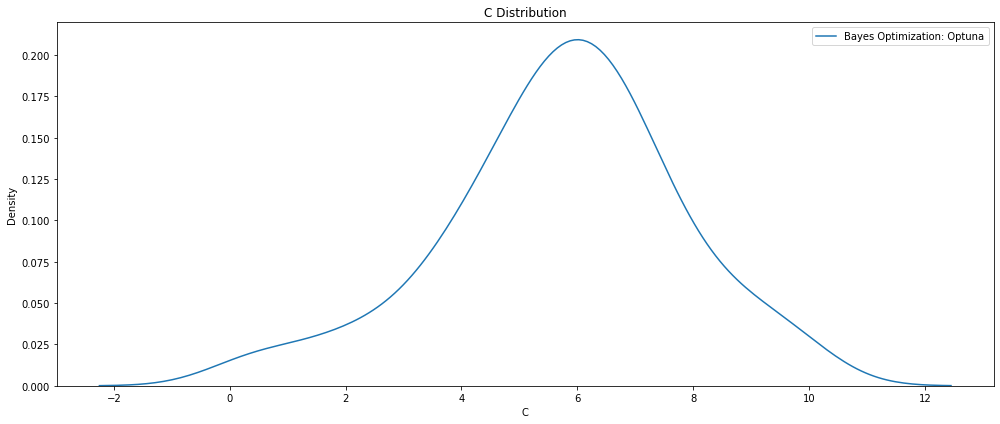

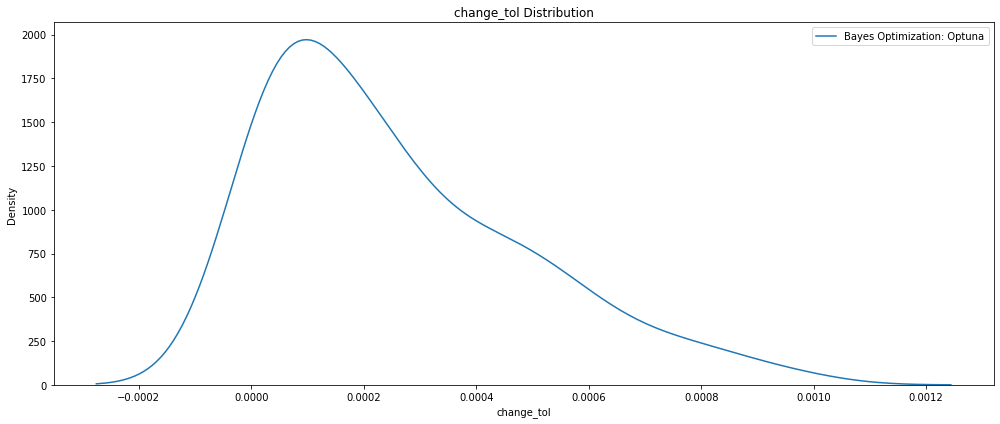

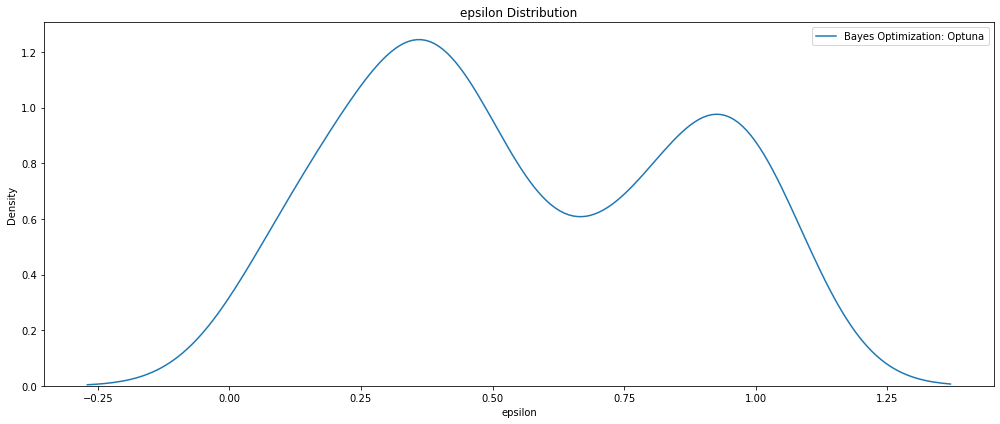

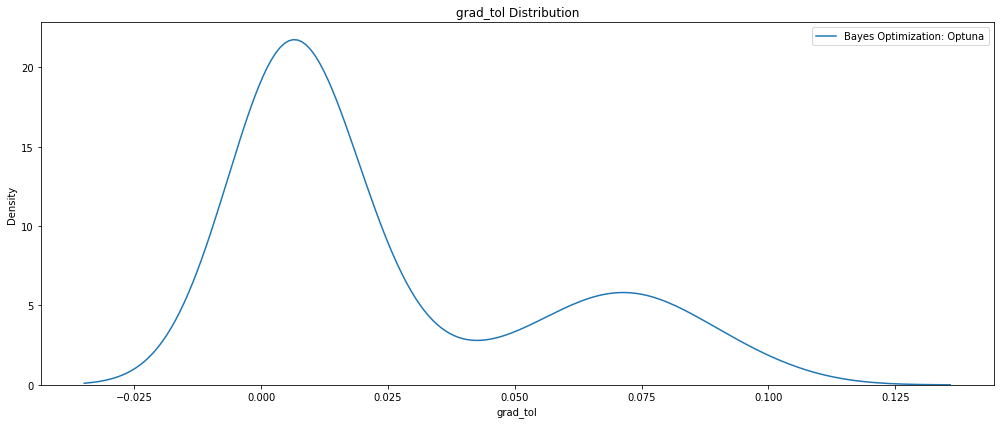

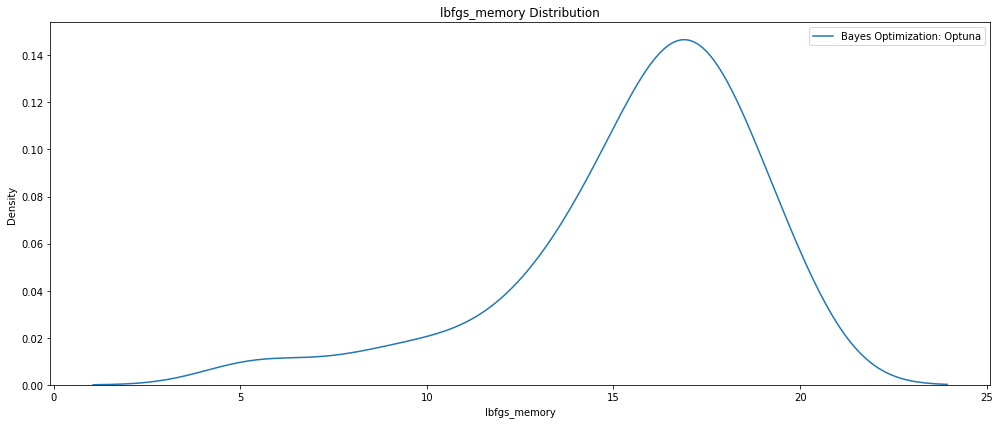

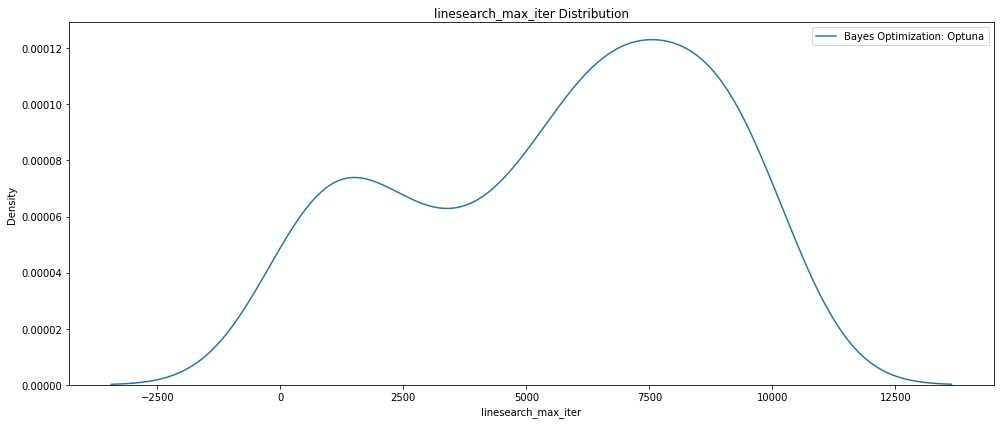

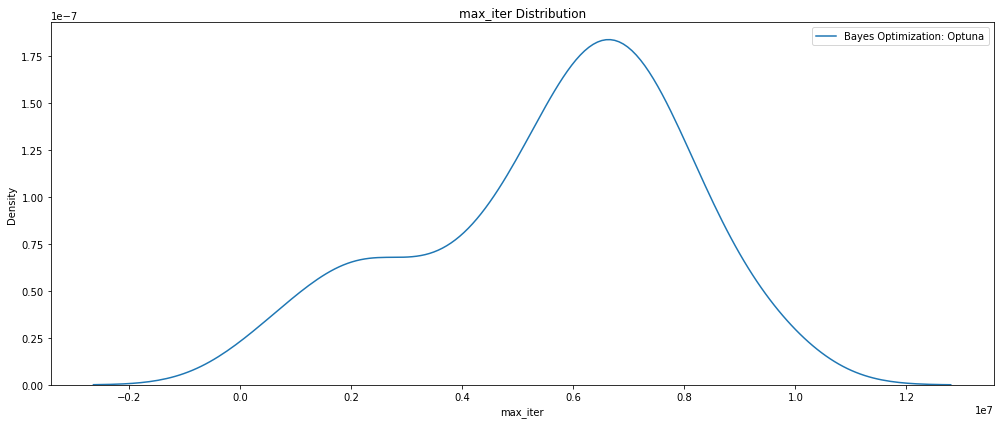

In [ ]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(trials_df.columns):
    if hpo not in ['iteration', 'rmse', 'datetime_start', 'datetime_complete',
                   'duration', 'loss', 'penatly', 'penalized_intercept', 'state']: 
        plt.figure(figsize=(14,6))
        # Plot the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(trials_df[hpo], label='Bayes Optimization: Optuna')
            plt.legend(loc=0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

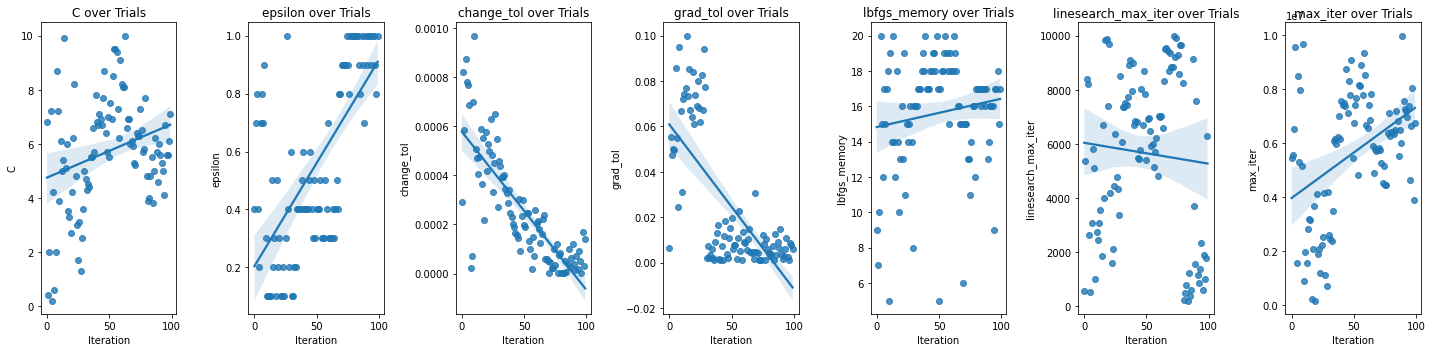

In [ ]:
# Plot quantitive hyperparameters
fig, axs = plt.subplots(1, 7, figsize=(20,5))
i = 0
axs = axs.flatten()
for i, hpo in enumerate(['C', 'epsilon', 'change_tol', 
                         'grad_tol', 'lbfgs_memory', 
                         'linesearch_max_iter', 'max_iter']):
  # Scatterplot
  sns.regplot('iteration', hpo, data=trials_df, ax=axs[i]) 
  axs[i].set(xlabel='Iteration', ylabel='{}'.format(hpo), 
             title='{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/UsedCarsCarGurus/Models/ML/LinearSVR/Optuna/Model_Explanations/

/content/drive/MyDrive/UsedCarsCarGurus/Models/ML/LinearSVR/Optuna/Model_Explanations


In [ ]:
# Visualize parameter importances
fig = optuna.visualization.plot_param_importances(study)
py.plot(fig, filename='paramImportance_LinearSVR_Optuna_100_GPU.html')
fig.show()

In [ ]:
# Visualize empirical distribution function
fig = optuna.visualization.plot_edf(study)
py.plot(fig, filename='edf_LinearSVR_Optuna_100_GPU.html')
fig.show()

In [ ]:
# Arrange best parameters to fit model for model metrics
params = study.best_params   
params

{'penalty': 'l1',
 'loss': 'epsilon_insensitive',
 'penalized_intercept': 'True',
 'max_iter': 5707704,
 'linesearch_max_iter': 8700,
 'lbfgs_memory': 15,
 'C': 6.1,
 'grad_tol': 0.0014169963255906024,
 'change_tol': 5.945860515361705e-05,
 'epsilon': 0.8}

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/UsedCarsCarGurus/Models/ML/LinearSVR/Optuna/Model_PKL/

/content/drive/MyDrive/UsedCarsCarGurus/Models/ML/LinearSVR/Optuna/Model_PKL


In [ ]:
# Re-create the best model and train on the training data
best_model = LinearSVR(**params)

# Fit the model
best_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'LinearSVR_Optuna_trials100_GPU.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('LinearSVR_Optuna_trials100_GPU')
# print(model)
# =============================================================================

In [ ]:
print('\nModel Metrics for LinearSVR HPO 100 GPU trials')
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

print('MAE train: %.3f, test: %.3f' % (
        mean_absolute_error(y_train.to_numpy(), y_train_pred.to_numpy()),
        mean_absolute_error(y_test.to_numpy(), y_test_pred.to_numpy())))
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train.to_numpy(), y_train_pred.to_numpy()),
        mean_squared_error(y_test.to_numpy(), y_test_pred.to_numpy())))
print('RMSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train.to_numpy(), y_train_pred.to_numpy(), 
                           squared=False),
        mean_squared_error(y_test.to_numpy(), y_test_pred.to_numpy(), 
                           squared=False)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train.to_numpy(), y_train_pred.to_numpy()),
        r2_score(y_test.to_numpy(), y_test_pred.to_numpy())))


Model Metrics for LinearSVR HPO 100 GPU trials
MAE train: 3709.540, test: 3709.540
MSE train: 24120718.807, test: 24120718.807
RMSE train: 4911.285, test: 4911.285
R^2 train: 0.737, test: 0.737


In [ ]:
# Evaluate on the testing data 
print('The best model from optimization scores {:.5f} MSE on the test set.'.format(mean_squared_error(y_test.to_numpy(), 
                                                                                                      y_test_pred.to_numpy())))
print('This was achieved using these conditions:')
print(trials_df.iloc[0])

The best model from optimization scores 24120718.80703 MSE on the test set.
This was achieved using these conditions:
iteration                                      68
rmse                                  4911.220907
datetime_start         2023-02-25 23:51:22.958612
datetime_complete      2023-02-25 23:51:25.654281
duration                   0 days 00:00:02.695669
C                                             6.1
change_tol                               0.000059
epsilon                                       0.8
grad_tol                                 0.001417
lbfgs_memory                                   15
linesearch_max_iter                          8700
loss                          epsilon_insensitive
max_iter                                  5707704
penalized_intercept                          True
penatly                                        l1
state                                    COMPLETE
Name: 68, dtype: object


## 1000 Trials

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/UsedCarsCarGurus/Models/ML/LinearSVR/Optuna/Model_PKL/

# Define a name for the trials
study_name = 'dask_optuna_linearsvr_1000_rmse_tpe'

/content/drive/MyDrive/UsedCarsCarGurus/Models/ML/LinearSVR/Optuna/Model_PKL


In [ ]:
# Define objective function with the parameters to be tested
def objective(trial, X_param, y_param):
    
    joblib.dump(study, 'LinearSVR_Optuna_1000_GPU.pkl')
    
    # Search parameters
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    max_iter = trial.suggest_int('max_iter', -1, 10e6)
    linesearch_max_iter = trial.suggest_int('linesearch_max_iter', 2000, 3000)  
    lbfgs_memory = trial.suggest_int('lbfgs_memory', 10, 25) 
    C = trial.suggest_float('C', 7, 15, step=0.1)
    grad_tol = trial.suggest_float('grad_tol', 1e-4, 1e-1)
    change_tol = trial.suggest_float('change_tol', 1e-4, 1e-1) 
    epsilon = trial.suggest_float('epsilon', 0.7, 1.5, step=0.1) 

    score = train_and_eval(X_param,
                           y_param,
                           penalty=penalty, 
                           loss='epsilon_insensitive', 
                           penalized_intercept='True', 
                           max_iter=max_iter, 
                           linesearch_max_iter=linesearch_max_iter, 
                           lbfgs_memory=lbfgs_memory, 
                           C=C, 
                           grad_tol=grad_tol, 
                           change_tol=change_tol, 
                           epsilon=epsilon, 
                           verbose=False)

    return score

In [ ]:
with timed('dask_optuna'):
    # Begin HPO trials 
    # Start timer for experiment
    start_time = datetime.now()
    print('%-20s %s' % ('Start Time', start_time))
    if os.path.isfile('LinearSVR_Optuna_1000_GPU.pkl'): 
      study = joblib.load('LinearSVR_Optuna_1000_GPU.pkl')
    else: 
      study = optuna.create_study(sampler=optuna.samplers.TPESampler(), 
                                  study_name=study_name,
                                  direction='minimize')
      
    # Optimize in parallel on Dask cluster
    with parallel_backend('dask'):
      study.optimize(lambda trial: objective(trial, X_train, y_train), 
                       n_trials=1000,
                       n_jobs=n_workers)

# End timer for experiment
end_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
print('%-20s %s' % ('End Time', end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))
print('\n')
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Lowest RMSE', study.best_value)

Start Time           2023-02-25 23:52:10.399855
- Trial RMSE: 7853.080669588964
- Trial RMSE: 7850.682282405743
- Trial RMSE: 7458.701717439172
- Trial RMSE: 7454.448915877995
- Trial RMSE: 7407.869727206258
- Trial RMSE: 7454.448878850693
- Trial RMSE: 7360.400873113823
- Trial RMSE: 7530.198478378883
- Trial RMSE: 8837.264644633717
- Trial RMSE: 7850.682282405743
- Trial RMSE: 7361.5147643837945
- Trial RMSE: 7361.5147643837945
- Trial RMSE: 7378.584830134606
- Trial RMSE: 7361.230186073336
- Trial RMSE: 7407.523468225229
- Trial RMSE: 7513.835525670115
- Trial RMSE: 7360.549921242021
- Trial RMSE: 7530.153468157979
- Trial RMSE: 7360.549680807819
- Trial RMSE: 7416.544725327243
- Trial RMSE: 7361.561481742992
- Trial RMSE: 7360.549921242021
- Trial RMSE: 7360.549680807819
- Trial RMSE: 7361.4325100427395
- Trial RMSE: 7530.113063325333
- Trial RMSE: 7360.545831258983
- Trial RMSE: 7360.40341972578
- Trial RMSE: 7397.083888391819
- Trial RMSE: 7416.048790459024
- Trial RMSE: 7456.070

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/UsedCarsCarGurus/Models/ML/LinearSVR/Optuna/trialOptions/

/content/drive/MyDrive/UsedCarsCarGurus/Models/ML/LinearSVR/Optuna/trialOptions


In [ ]:
# Output from HPO trials
trials_df = study.trials_dataframe()
trials_df.rename(columns={'number': 'iteration'}, inplace=True)
trials_df.rename(columns={'value': 'rmse'},inplace=True)
trials_df.rename(columns={'params_C': 'C'}, inplace=True)
trials_df.rename(columns={'params_change_tol': 'change_tol'}, inplace=True)
trials_df.rename(columns={'params_epsilon': 'epsilon'}, inplace=True)
trials_df.rename(columns={'params_grad_tol': 'grad_tol'}, inplace=True)
trials_df.rename(columns={'params_lbfgs_memory': 'lbfgs_memory'}, inplace=True)
trials_df.rename(columns={'params_linesearch_max_iter': 'linesearch_max_iter'}, 
                 inplace=True)
trials_df.rename(columns={'params_loss': 'loss'}, inplace=True)
trials_df.rename(columns={'params_max_iter': 'max_iter'}, inplace=True)
trials_df.rename(columns={'params_penalized_intercept': 'penalized_intercept'}, 
                 inplace=True)
trials_df.rename(columns={'params_penalty': 'penatly'}, inplace=True)
trials_df = trials_df.sort_values('rmse', ascending=True)
print(trials_df) 

# Write processed data to csv
trials_df.to_csv('LinearSVR_Optuna_1000_GPU.csv', index=False)

     iteration         rmse             datetime_start  \
638        638  4911.369260 2023-02-25 23:57:17.254572   
574        574  4919.158631 2023-02-25 23:56:33.961490   
867        867  4920.198370 2023-02-26 00:00:22.920844   
350        350  4932.002342 2023-02-25 23:54:19.596462   
349        349  4932.002342 2023-02-25 23:54:18.770582   
..         ...          ...                        ...   
889        889  8837.264645 2023-02-26 00:00:41.333290   
684        684  8837.268571 2023-02-25 23:57:51.215853   
645        645  8837.268571 2023-02-25 23:57:22.625484   
288        288  8837.276498 2023-02-25 23:53:41.916649   
921        921  8837.279309 2023-02-26 00:01:08.940784   

             datetime_complete               duration     C  change_tol  \
638 2023-02-25 23:57:18.745134 0 days 00:00:01.490562  11.6    0.000116   
574 2023-02-25 23:56:35.126842 0 days 00:00:01.165352  10.3    0.000101   
867 2023-02-26 00:00:24.189521 0 days 00:00:01.268677  12.0    0.000101   
350

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/UsedCarsCarGurus/Models/ML/LinearSVR/Optuna/Model_Explanations/

/content/drive/MyDrive/UsedCarsCarGurus/Models/ML/LinearSVR/Optuna/Model_Explanations


In [ ]:
# Plot_optimization_history: shows the scores from all trials as well as the best score so far at each point.
fig = optuna.visualization.plot_optimization_history(study)
py.plot(fig, filename='optimizationHistory_LinearSVR_Optuna_1000_GPU.html')
fig.show()

In [ ]:
# plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
fig = optuna.visualization.plot_parallel_coordinate(study)
py.plot(fig, filename='parallelCoordinate_LinearSVR_Optuna_1000_GPU.html')
fig.show()

In [ ]:
# plot_slice: shows the change of the hyperparamters space over the search. 
fig = optuna.visualization.plot_slice(study)
py.plot(fig, filename='slice_LinearSVR_Optuna_1000_GPU.html')
fig.show()

In [ ]:
# plot_contour: plots parameter interactions on an interactive chart. 
fig = optuna.visualization.plot_contour(study, params=['C',
                                                       'epsilon',
                                                       'change_tol',
                                                       'grad_tol',
                                                       'lbfgs_memory',
                                                       'linesearch_max_iter',
                                                       'max_iter'])
py.plot(fig, filename='contour_LinearSVR_Optuna_1000_GPU.html')
fig.show() 

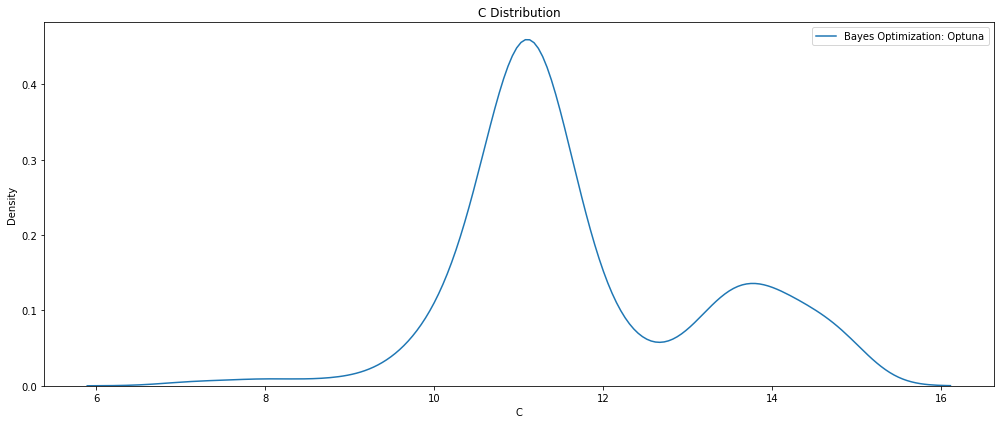

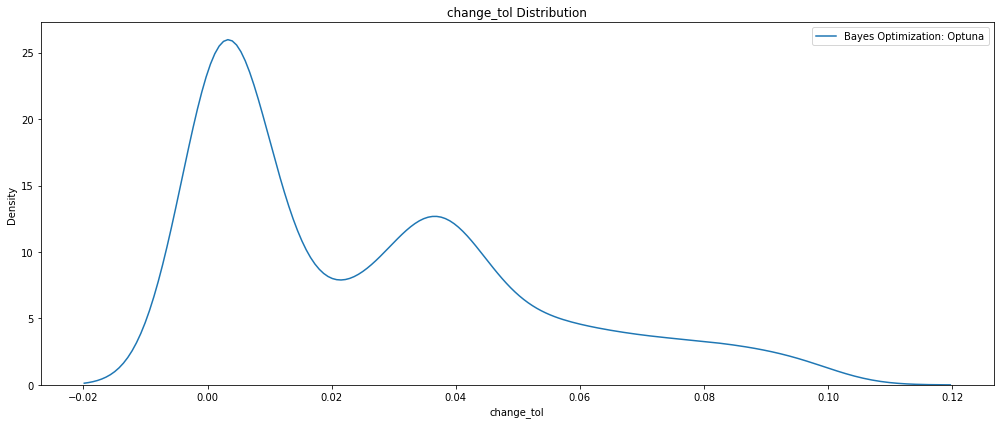

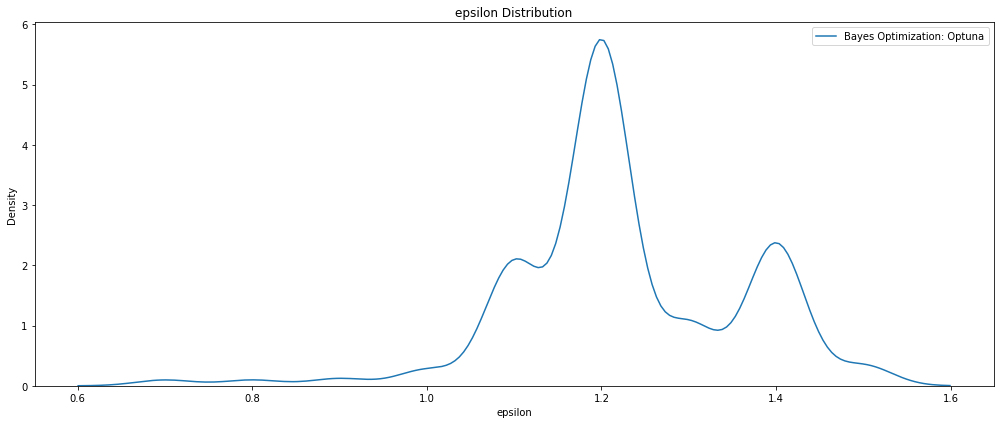

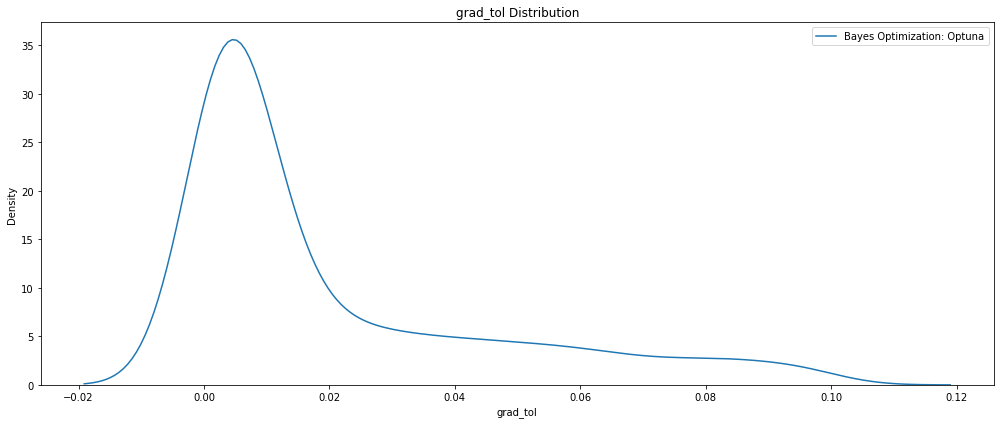

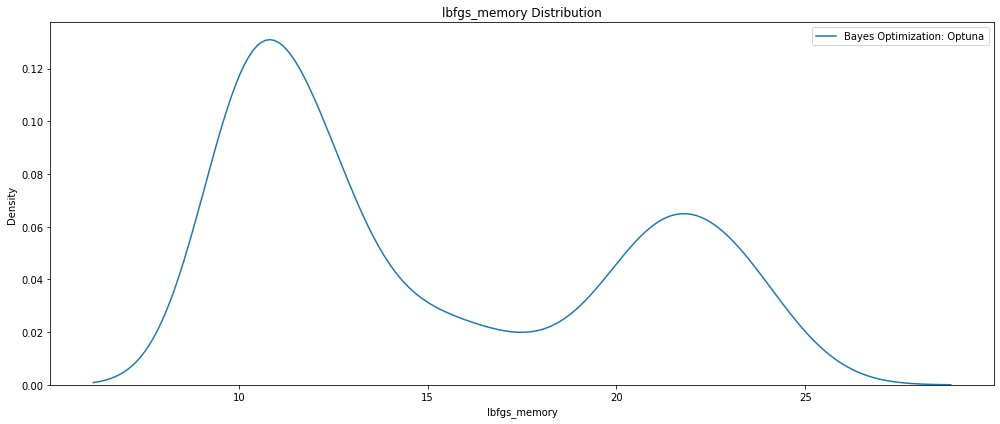

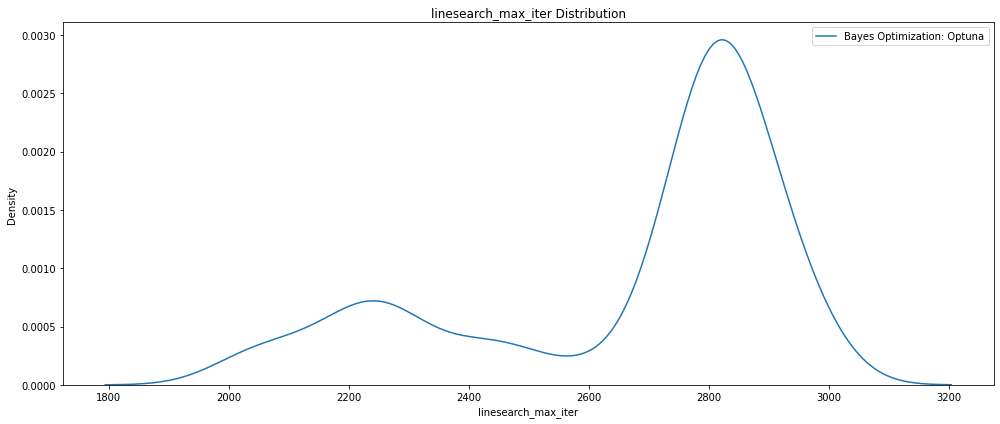

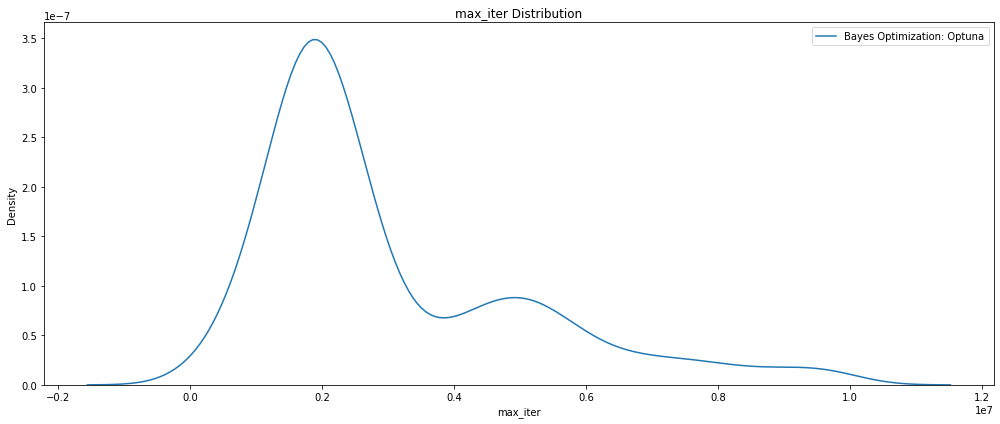

In [ ]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(trials_df.columns):
    if hpo not in ['iteration', 'rmse', 'datetime_start', 'datetime_complete',
                   'duration', 'loss', 'penatly', 'penalized_intercept', 'state']: 
        plt.figure(figsize=(14,6))
        # Plot the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(trials_df[hpo], label='Bayes Optimization: Optuna')
            plt.legend(loc=0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

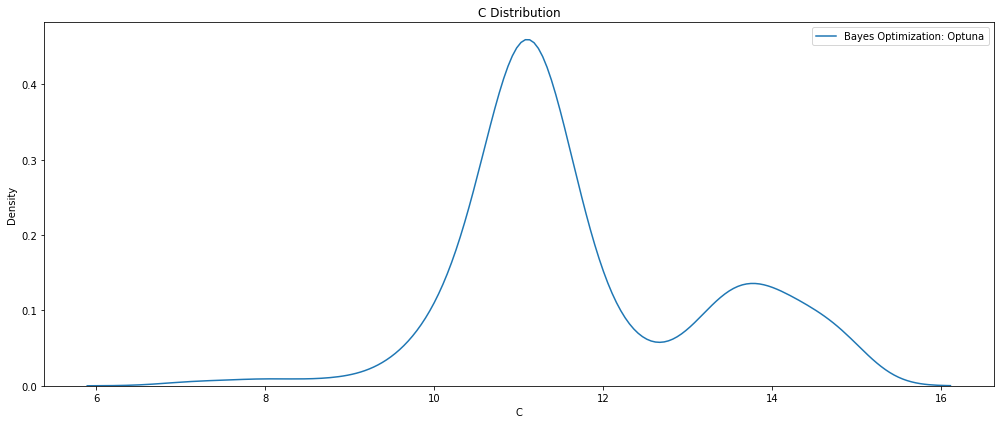

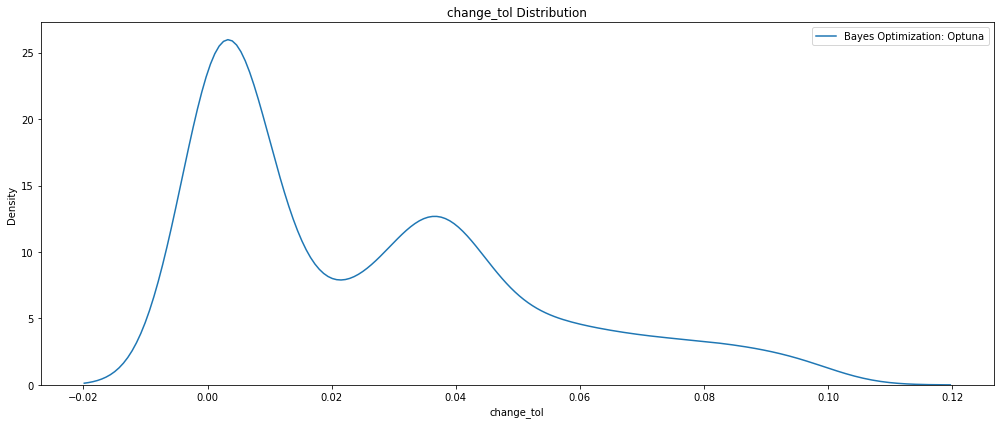

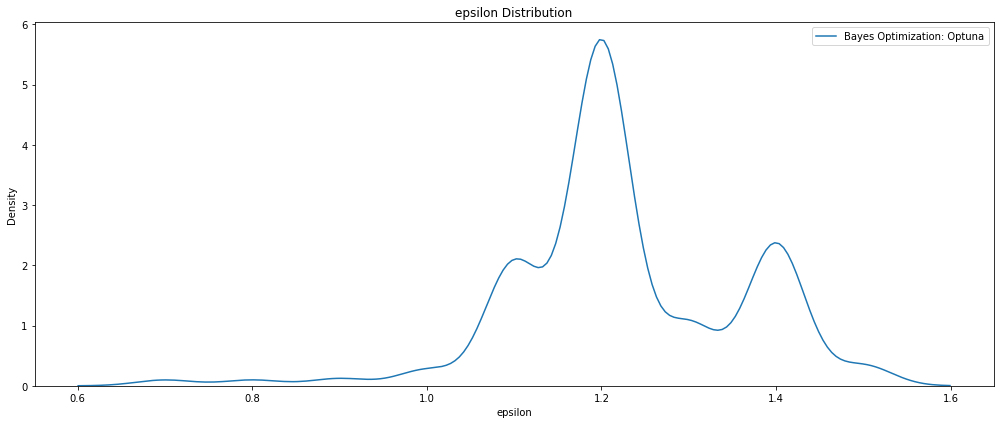

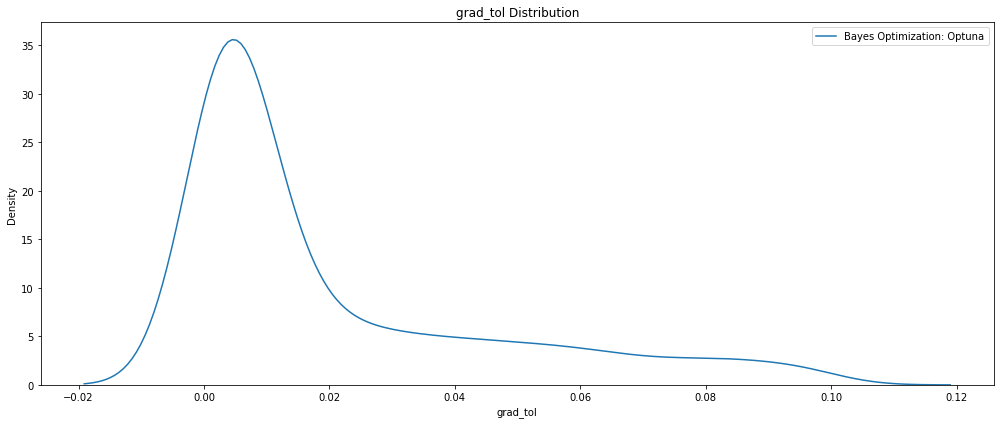

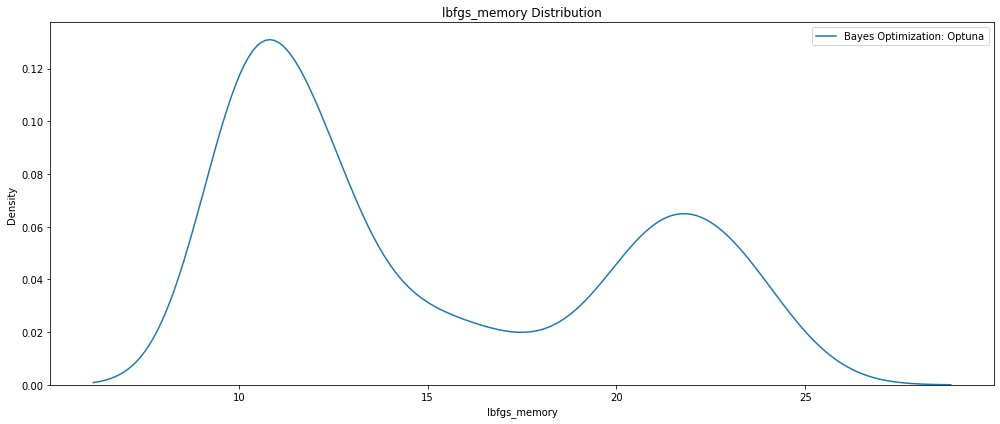

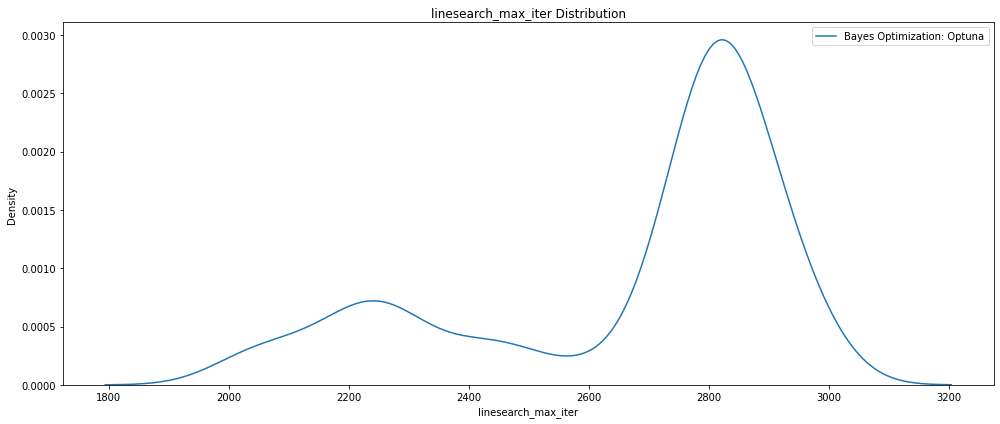

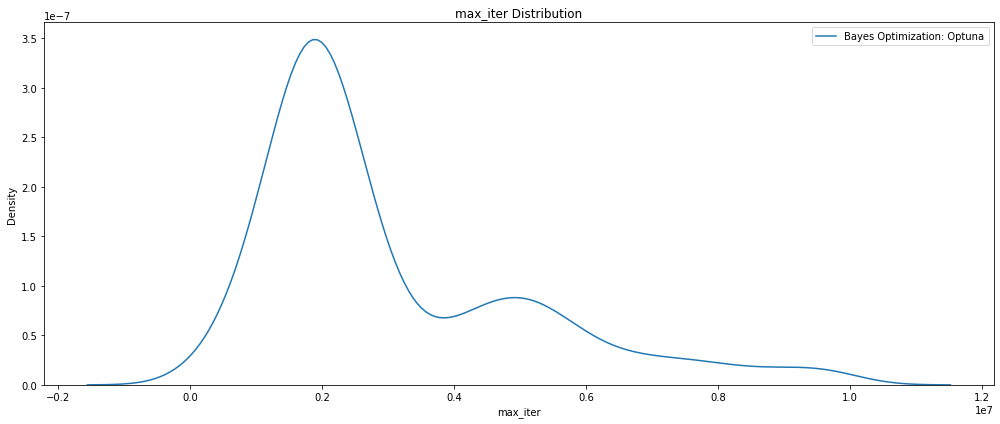

In [ ]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(trials_df.columns):
    if hpo not in ['iteration', 'rmse', 'datetime_start', 'datetime_complete',
                   'duration', 'loss', 'penatly', 'penalized_intercept', 'state']: 
        plt.figure(figsize=(14,6))
        # Plot the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(trials_df[hpo], label='Bayes Optimization: Optuna')
            plt.legend(loc=0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

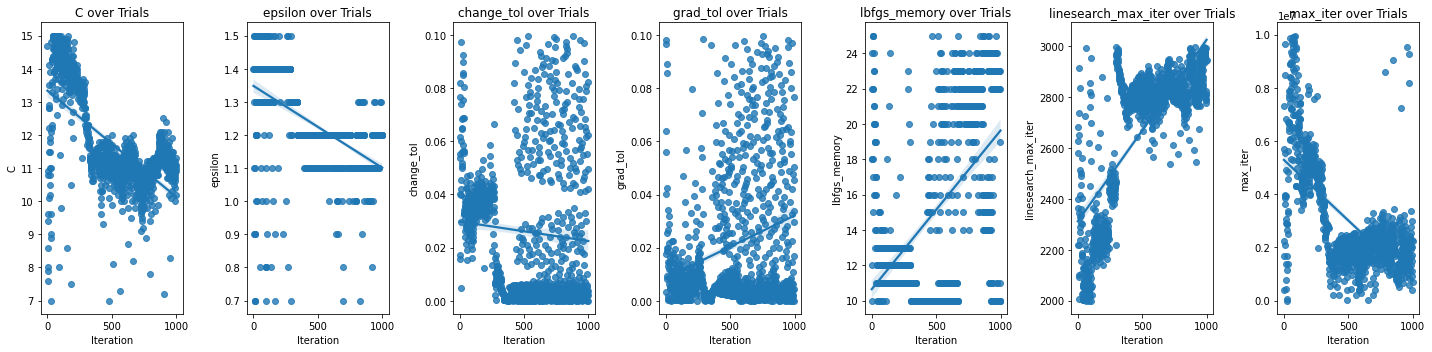

In [9]:
# Plot quantitive hyperparameters
fig, axs = plt.subplots(1, 7, figsize=(20,5))
i = 0
axs = axs.flatten()
for i, hpo in enumerate(['C', 'epsilon', 'change_tol', 
                         'grad_tol', 'lbfgs_memory', 
                         'linesearch_max_iter', 'max_iter']):
  # Scatterplot
  sns.regplot('iteration', hpo, data=trials_df, ax=axs[i]) 
  axs[i].set(xlabel='Iteration', ylabel='{}'.format(hpo), 
             title='{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

In [11]:
# Visualize parameter importances
fig = optuna.visualization.plot_param_importances(study)
py.plot(fig, filename='paramImportance_LinearSVR_Optuna_1000_GPU.html')
fig.show()

In [12]:
# Visualize empirical distribution function
fig = optuna.visualization.plot_edf(study)
py.plot(fig, filename='edf_LinearSVR_Optuna_1000_GPU.html')
fig.show()

In [ ]:
# Arrange best parameters to fit model for model metrics
params = study.best_params   
params

{'penalty': 'l1',
 'max_iter': 2459810,
 'linesearch_max_iter': 2773,
 'lbfgs_memory': 23,
 'C': 11.600000000000001,
 'grad_tol': 0.00020361102019258634,
 'change_tol': 0.00011646771570061629,
 'epsilon': 1.1}

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/UsedCarsCarGurus/Models/ML/LinearSVR/Optuna/Model_PKL/

/content/drive/MyDrive/UsedCarsCarGurus/Models/ML/LinearSVR/Optuna/Model_PKL


In [ ]:
# Re-create the best model and train on the training data
best_model = LinearSVR(**params)

# Fit the model
best_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'LinearSVR_Optuna_trials1000_GPU.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('LinearSVR_Optuna_trials1000_GPU.pkl')
# print(model)
# =============================================================================

In [ ]:
print('\nModel Metrics for LinearSVR HPO 1000 GPU trials')
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

print('MAE train: %.3f, test: %.3f' % (
        mean_absolute_error(y_train.to_numpy(), y_train_pred.to_numpy()),
        mean_absolute_error(y_test.to_numpy(), y_test_pred.to_numpy())))
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train.to_numpy(), y_train_pred.to_numpy()),
        mean_squared_error(y_test.to_numpy(), y_test_pred.to_numpy())))
print('RMSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train.to_numpy(), y_train_pred.to_numpy(), 
                           squared=False),
        mean_squared_error(y_test.to_numpy(), y_test_pred.to_numpy(), 
                           squared=False)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train.to_numpy(), y_train_pred.to_numpy()),
        r2_score(y_test.to_numpy(), y_test_pred.to_numpy())))


Model Metrics for LinearSVR HPO 1000 GPU trials
MAE train: 3720.125, test: 3720.125
MSE train: 24198219.053, test: 24198219.053
RMSE train: 4919.169, test: 4919.169
R^2 train: 0.736, test: 0.736


In [ ]:
# Evaluate on the testing data 
print('The best model from optimization scores {:.5f} MSE on the test set.'.format(mean_squared_error(y_test.to_numpy(), 
                                                                                                      y_test_pred.to_numpy())))
print('This was achieved using these conditions:')
print(trials_df.iloc[0])

The best model from optimization scores 24198219.05283 MSE on the test set.
This was achieved using these conditions:
iteration                                     638
rmse                                   4911.36926
datetime_start         2023-02-25 23:57:17.254572
datetime_complete      2023-02-25 23:57:18.745134
duration                   0 days 00:00:01.490562
C                                            11.6
change_tol                               0.000116
epsilon                                       1.1
grad_tol                                 0.000204
lbfgs_memory                                   23
linesearch_max_iter                          2773
max_iter                                  2459810
penatly                                        l1
state                                    COMPLETE
Name: 638, dtype: object
